In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/videoreptiles/COSTA RICA IN 4K 60fps HDR (ULTRA HD).mp4


Using device: cuda
Number of frames extracted: 27
Epoch 1/60, Loss: 0.3571935906012853
Model saved!
Epoch 2/60, Loss: 0.30036668010056017
Model saved!
Epoch 3/60, Loss: 0.3077312852380176
Epoch 4/60, Loss: 0.2964541171723976
Model saved!
Epoch 5/60, Loss: 0.31318323230991757
Epoch 6/60, Loss: 0.24849114243523215
Model saved!
Epoch 7/60, Loss: 0.21045047258531366
Model saved!
Epoch 8/60, Loss: 0.15717864579171872
Model saved!
Epoch 9/60, Loss: 0.127163562309579
Model saved!
Epoch 10/60, Loss: 0.09841274833248463
Model saved!
Epoch 11/60, Loss: 0.08842296696840397
Model saved!
Epoch 12/60, Loss: 0.0617276739666704
Model saved!
Epoch 13/60, Loss: 0.05143286972558902
Model saved!
Epoch 14/60, Loss: 0.04341195071023927
Model saved!
Epoch 15/60, Loss: 0.03811594200373899
Model saved!
Epoch 16/60, Loss: 0.030405618220490094
Model saved!
Epoch 17/60, Loss: 0.027426485119940478
Model saved!
Epoch 18/60, Loss: 0.0237148439612065
Model saved!
Epoch 19/60, Loss: 0.01971863975966698
Model saved!
Ep

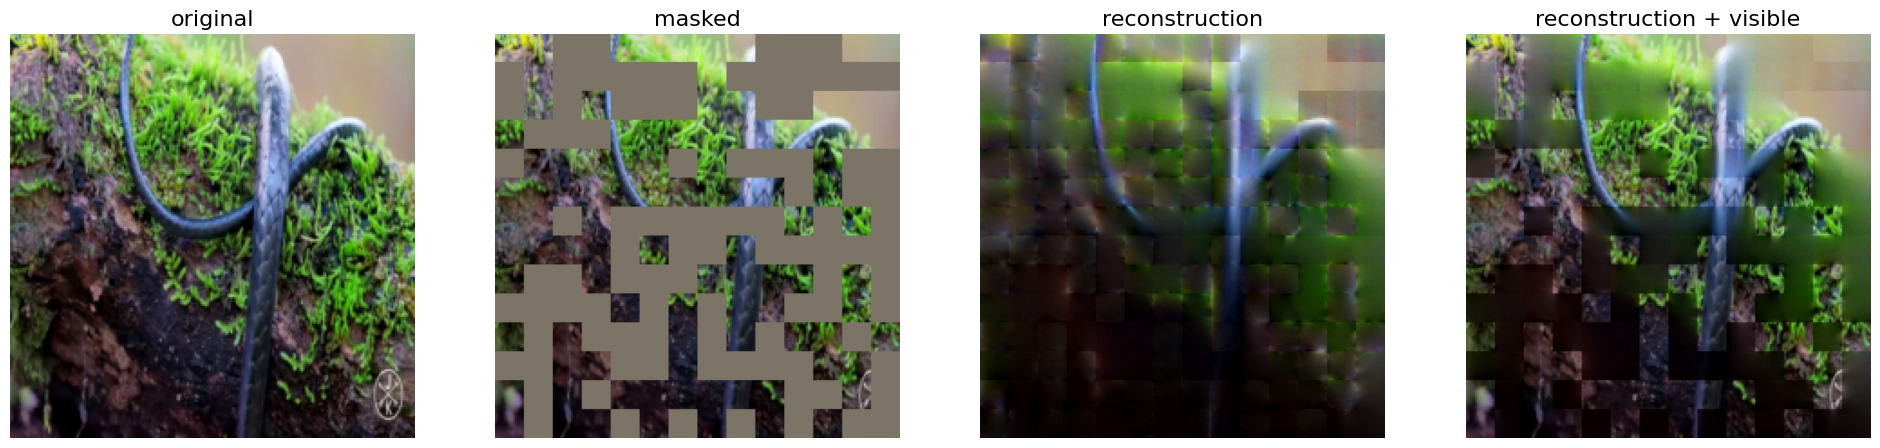

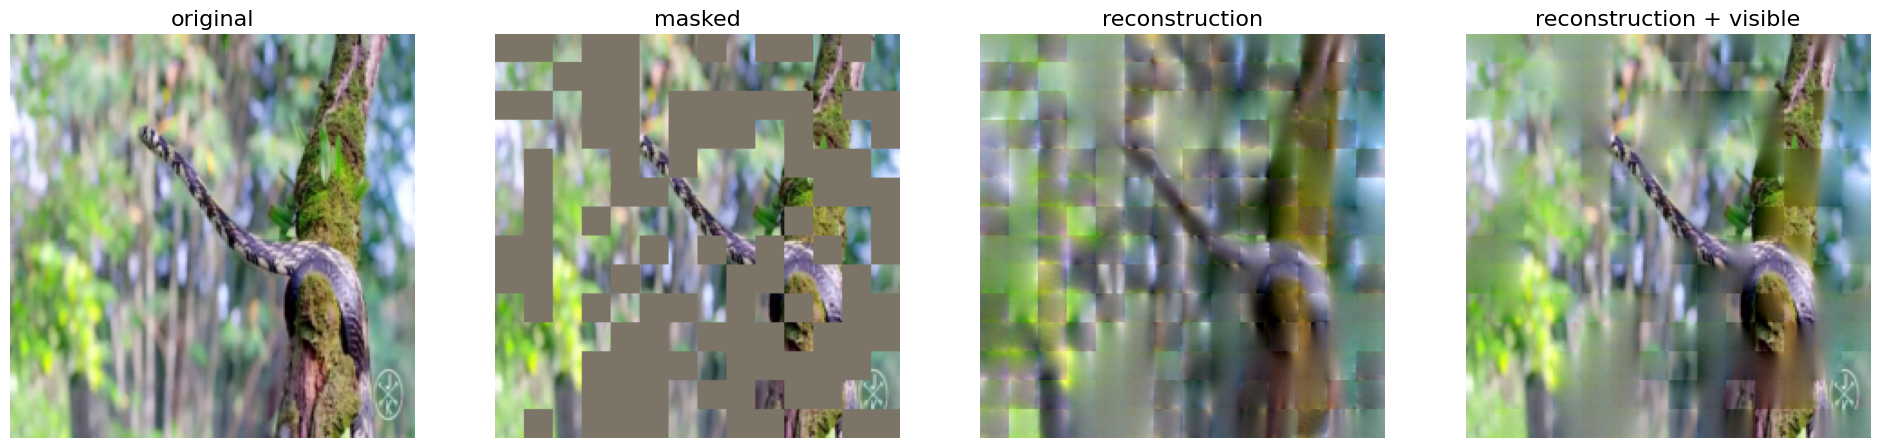

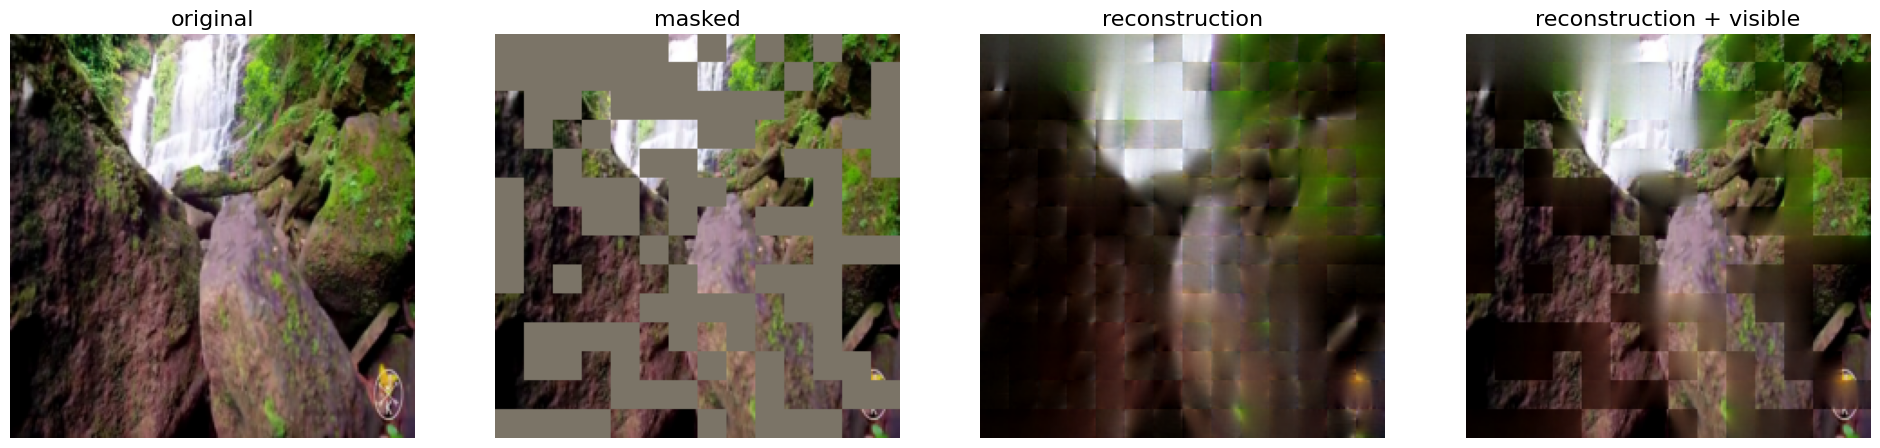

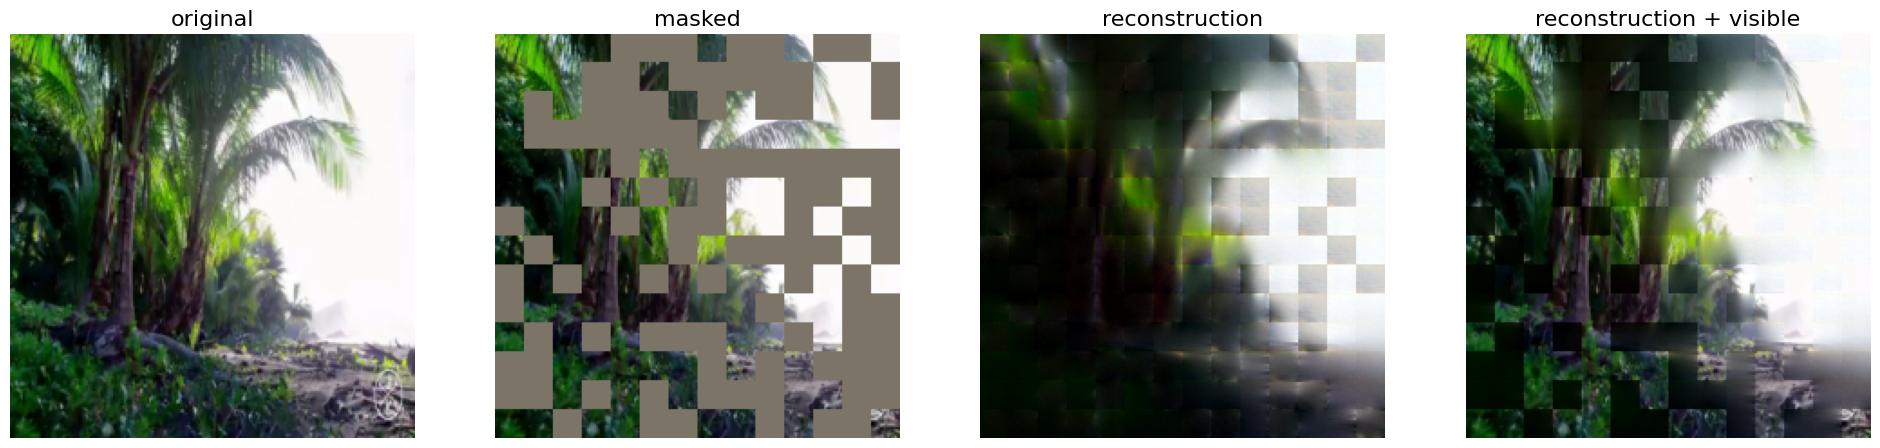

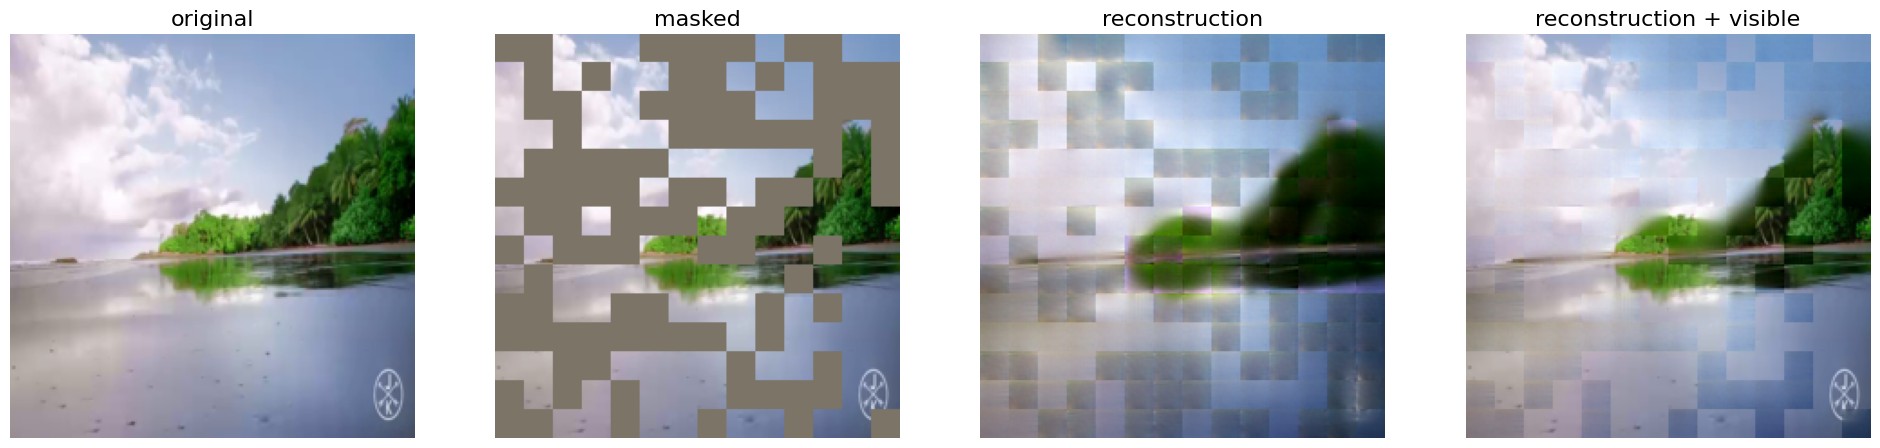

In [10]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the feature extractor with do_rescale=False
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

# Define paths and load model
video_path = "/kaggle/input/videoreptiles/COSTA RICA IN 4K 60fps HDR (ULTRA HD).mp4"  # Replace with the actual path to your video file
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)  # Move model to GPU

# Define hyperparameters
batch_size = 8
num_epochs = 60
learning_rate = 1e-4
weight_decay = 1e-5
warmup_steps = 15
mask_size = 64  # Size of the mask
model.config.mask_ratio = 0.5

# Function to show images
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    pixel_values = pixel_values.to(device)  # Move input to GPU
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()  # Move back to CPU for visualization

    mask = outputs.mask.detach().cpu()  # Move mask to CPU
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 * 3)
    mask = model.unpatchify(mask)
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', pixel_values.detach().cpu())
    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + y * mask

    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

# Function to extract frames from a video
def extract_frames(video_path, frame_rate=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frames = []
    success, image = cap.read()
    count = 0
    while success:
        if count % frame_rate == 0:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(image_rgb))
        success, image = cap.read()
        count += 1
    cap.release()
    return frames

# Define custom dataset class
class FrameDataset(Dataset):
    def __init__(self, frames, feature_extractor):
        self.frames = frames
        self.feature_extractor = feature_extractor
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.RandomRotation(15),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        frame = self.transform(frame)
        pixel_values = self.feature_extractor(images=frame, return_tensors="pt").pixel_values.squeeze(0)
        return pixel_values

# Extract frames from the video
frames = extract_frames(video_path, frame_rate=360)
print(f"Number of frames extracted: {len(frames)}")

# Split frames into training and test sets
train_frames, test_frames = train_test_split(frames, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = FrameDataset(train_frames, feature_extractor)
test_dataset = FrameDataset(test_frames, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define a learning rate scheduler with warmup
def lr_lambda(current_step: int):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(0.0, float(num_epochs * len(train_loader) - current_step) / float(max(1, num_epochs * len(train_loader) - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda)


def hybrid_loss(original, reconstructed, alpha=0.4):
    """Computes a hybrid loss combining MSE and SSIM."""
    # Compute MSE Loss
    mse_loss = F.mse_loss(reconstructed, original)

    # Detach tensors for SSIM computation (since SSIM is not differentiable)
    original_np = original.permute(0, 2, 3, 1).cpu().detach().numpy()  # Detach before NumPy conversion
    reconstructed_np = reconstructed.permute(0, 2, 3, 1).cpu().detach().numpy()  # Detach before NumPy conversion

    # Compute SSIM Loss
    ssim_loss = np.mean([1 - structural_similarity(o, r, multichannel=True, win_size=7, channel_axis=-1,data_range=1.0)
                         for o, r in zip(original_np, reconstructed_np)])

    # Combine losses
    loss = alpha * mse_loss + (1 - alpha) * torch.tensor(ssim_loss).to(device)
    return loss


# Early stopping parameters
best_loss = float('inf')
patience = 5
patience_counter = 0

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(batch)
        y = model.unpatchify(outputs.logits)

        # Compute hybrid loss
        loss = hybrid_loss(batch, y, alpha=0.4)  # You can adjust alpha as needed
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save the model
        model_save_path = "best_model.pth"  # Replace with your desired path
        torch.save(model.state_dict(), model_save_path)
        print("Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

def calculate_metrics(original, reconstructed):
    original = original.permute(0, 2, 3, 1).cpu().numpy()
    reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()
    data_range = original.max() - original.min()
    psnr = np.mean([peak_signal_noise_ratio(o, r, data_range=data_range) for o, r in zip(original, reconstructed)])
    
    # Explicitly setting win_size and channel_axis for SSIM calculation
    ssim = np.mean([
        structural_similarity(o, r, data_range=data_range, multichannel=True, win_size=7, channel_axis=-1)
        for o, r in zip(original, reconstructed)
    ])
    
    return psnr, ssim
# Evaluate on test set
model.eval()
test_loss = 0
psnr_total = 0
ssim_total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Move batch to GPU
        outputs = model(batch)
        y = model.unpatchify(outputs.logits)

        # Compute hybrid loss
        loss = hybrid_loss(batch, y, alpha=0.4)  # Same alpha as during training
        test_loss += loss.item()

        # Calculate metrics
        psnr, ssim = calculate_metrics(batch, y)
        psnr_total += psnr
        ssim_total += ssim

# Calculate averages for the test set
test_loss /= len(test_loader)
psnr_total /= len(test_loader)
ssim_total /= len(test_loader)

# Print test results
print(f"Test Loss: {test_loss}")
print(f"Average PSNR: {psnr_total}")
print(f"Average SSIM: {ssim_total}")

# Visualize a few test samples
for idx, frame in enumerate(test_frames[:5]):
    pixel_values = feature_extractor(images=frame, return_tensors="pt").pixel_values.to(device)  # Move to GPU
    visualize(pixel_values, model)
